In [1]:
import numpy as np
import astropy.io.fits as fits
import json
import os
import glob
import sys
import healpy as hp
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io.fits import getdata
from pathlib import Path
from itertools import compress
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
def read_ref(param):
    Mv, rhl_pc = np.loadtxt(param["cat_dg"], usecols=(8, 10), unpack=True)

    mM_GC, Mv_GC, rhl_arcmin_GC = np.loadtxt(
        param["cat_gc"], usecols=(5, 6, 7), unpack=True
    )

    dist_GC = 10.0 ** (1 + (mM_GC / 5))

    rhl_pc_GC = (rhl_arcmin_GC / (57.3 * 60)) * dist_GC

    rhl_pc = np.concatenate((rhl_pc, rhl_pc_GC))

    Mv = np.concatenate((Mv, Mv_GC))

    return Mv, rhl_pc

In [3]:
def rd2d(x, y, xmin, xmax, ymin, ymax, x_steps, y_steps, n_random):
    """This function returns a 2D random of point based on an informed distribution.

    Parameters
    ----------
    x : list of float
        List of points. First dimension.
    y : list of float
        List of points. Second dimension.
    xmin : float
        Minimum in first dimension.
    xmax : float
        Maximum in first dimension.
    ymin : float
        Minimum in second dimension.
    ymax : float
        Maximum in second dimension.
    x_steps : int
        Amount of steps in first dimension.
    y_steps : int
        Amount of steps in second dimension.
    n_random : int
        Amount of points in output.

    Returns
    -------
    Array-like
        First and second dimension of random points.
    """
    h, xedges, ydeges, img = plt.hist2d(
        x, y, bins=[x_steps, y_steps], range=[[xmin, xmax], [ymin, ymax]], density=True
    )
    plt.clf()
    H = gaussian_filter(h.T, sigma=50)
    H /= np.sum(H)
    p = H.flatten()
    n = np.random.choice(np.arange(len(p)), size=n_random, replace=True, p=p)
    x_random = n % x_steps
    y_random = n / y_steps
    x_random = x_random * (xmax - xmin)
    y_random = y_random * (ymax - ymin)
    x_random = x_random / x_steps
    y_random = y_random / y_steps
    x_random += xmin
    y_random += ymin
    return x_random, y_random



In [4]:
def mv_hlr_from_data(N_desired, param, Mv_min=-14.0, Mv_max=2):

    globals().update(param)

    rhl_pc_min = 10.**(1.7 * log10_rexp_min)
    rhl_pc_max = 10.**(1.7 * log10_rexp_max)

    Mv, rhl_pc = read_ref(param)

    log10_rhl_pc = np.log10(rhl_pc)

    X, Y = rd2d(Mv, log10_rhl_pc, Mv_min, Mv_max, np.log10(rhl_pc_min), np.log10(rhl_pc_max), 1000, 1000, N_desired)

    return X, Y

In [5]:
def select_ipix_clus(nside, ra_min, ra_max, dec_min, dec_max, inclusive=False):
    """Select ipix from a region of sky following same ra and dec ranges
    (insted of Healpix standard geodesics).

    Parameters
    ----------
    nside : integer
        Nside of HealPixels.
    ra_min : float
        Minimum in RA (deg).
    ra_max : float
        Maximum in RA (deg).
    dec_min : float
        Minimum in DEC (deg).
    dec_max : float
        Maximum in DEC (deg).
    inclusive : bool, optional
        If True, all the pixels that are in that region will be selected.
        If False, only the pixels with the center in that region will be
        selected, by default False.

    Returns
    -------
    list
        Sample of requested pixels.
    """
    theta1 = np.pi / 2 - np.deg2rad(dec_max)
    theta2 = np.pi / 2 - np.deg2rad(dec_min)
    hp_all = hp.query_strip(
        nside, theta1, theta2, inclusive=inclusive, nest=False, buff=None
    )
    ra_c, dec_c = hp.pix2ang(nside, hp_all, nest=False, lonlat=True)
    cond = (ra_c > ra_min) & (ra_c <= ra_max)
    hp_sel = hp_all[cond]
    hp_sel_nest = hp.ring2nest(nside, hp_sel)
    return hp_sel_nest

In [6]:
def download_iso(version, phot_system, Z, age, av_ext, IMF_author, out_file, iter_max):
    """Submit a request of an isochrone from PADOVA schema, download the file
    requested and uses as an input file to the stellar population of clusters.
    Good reference to Fe/H and M/H and Z:
    https://www.aanda.org/articles/aa/full_html/2014/03/aa20956-12/aa20956-12.html

    Parameters
    ----------
    version : str
        Version of PADOVA/PARSEC isochrones ('3.4', '3.5' or '3.6')
    phot_system : str
        Photometric system of isochrones. For DES uses 'decam'.
    Z : float
        Amount of metals in mass. Z_sun = 0.019.
    age : float
        Age of isochrone in years (not log age).
    av_ext : float
        Extinction in V band. Usually 0.000.
    out_file : str
        Name of the output file, which is written as
        output.
    """

    # os.system('mkdir -p ' + out_file.split('/')[0])
    count = 0
    file_is_empty = True
    # Selecting IMF:
    if IMF_author == "Kroupa":
        file_IMF = "imf_kroupa_orig.dat"
    if IMF_author == "Salpeter":
        file_IMF = "imf_salpeter.dat"
    if IMF_author == "Chabrier_exp":
        file_IMF = "imf_chabrier_exponential.dat"

    main_pars = (
        "track_parsec=parsec_CAF09_v1.2S&track_colibri=parsec_CAF09_v1.2S_S_LMC_08_web&track_postagb="
        +"no&n_inTPC=10&eta_reimers=0.2&kind_interp=1&kind_postagb=-1&kind_tpagb=-1&kind_pulsecycle="
        +"0&kind_postagb=-1&kind_mag=2&kind_dust=0&extinction_coeff=constant&extinction_curve="
        +"cardelli&kind_LPV=1&dust_sourceM=dpmod60alox40&dust_sourceC=AMCSIC15&imf_file=tab_imf/"
        +file_IMF
        +"&output_kind=0&output_evstage=1&output_gzip=0"
    )
    webserver = "http://stev.oapd.inaf.it"
    if phot_system == "des":
        phot_system = "decam"

    while (file_is_empty) & (count < iter_max):
        print("Iteration {:d} to download PARSEC isochrone.".format(count + 1))
        try:
            os.system(
                (
                    "wget -o lixo -Otmp --post-data='submit_form=Submit&cmd_version={}&photsys_file=tab_mag_odfnew/tab_mag_{}.dat&photsys_version=YBC&output_kind=0&output_evstage=1&isoc_isagelog=0&isoc_agelow={:.2e}&isoc_ageupp={:.2e}&isod_dage=0&isoc_ismetlog=0&isoc_zlow={:.6f}&isoc_zupp={:.6f}&isod_dz=0&extinction_av={:.3f}&{}' {}/cgi-bin/cmd_{}".format(
                        version,
                        phot_system,
                        age,
                        age,
                        Z,
                        Z,
                        av_ext,
                        main_pars,
                        webserver,
                        version,
                    )
                ).replace("e+", "e")
            )
        except:
            print("No communication with {}".format(webserver))
        with open("tmp") as ff:
            aaa = ff.readlines()
            for i, j in enumerate(aaa):
                if "/output" in j:
                    out_file_tmp = (
                        "output"
                        +j.split(
                            "/output",
                        )[
                            1
                        ][0:12]
                        +".dat"
                    )
        os.system(
            "wget -o lixo -O{} {}/tmp/{}".format(out_file_tmp, webserver, out_file_tmp)
        )
        os.system("mv {} {}".format(out_file_tmp, out_file))

        file_is_empty = os.stat(out_file).st_size == 0

        count += 1

In [7]:
def gen_clus_file(param):
    """This function generates the file with features of simulated clusters,
    based on numerical simulations within the range of parameters.

    Parameters
    ----------
    param : dictionary
        Dictionary with all the list of parameters.

    Returns
    -------
    list
        RA_pix, DEC_pix, r_exp, ell, pa, dist, mass, mM, hp_sample_un
        Position of the center of ipix, exponential radius in parsecs,
        ellipticity. positional angle, distance in parsecs, mass in
        Sun masses, distance modulus, and list of ipix sampled.
    """

    globals().update(param)

    border_extract_ra = border_extract / np.cos(np.deg2rad(0.5 * (dec_max + dec_min)))
    hp_sample_un = select_ipix_clus(
        nside_ini,
        ra_min + border_extract_ra,
        ra_max - border_extract_ra,
        dec_min + border_extract,
        dec_max - border_extract,
    )

    RA_pix, DEC_pix = hp.pix2ang(nside_ini, hp_sample_un, nest=True, lonlat=True)

    c = SkyCoord(ra=RA_pix * u.degree, dec=DEC_pix * u.degree, frame="icrs")
    L = c.galactic.l.degree
    B = c.galactic.b.degree
    objects_filepath = Path(results_path, "objects.dat")
    with open(objects_filepath, "w") as obj_file:
        # Creating random distances, masses, ellipticities and positional
        # angles based on limits required, and printing to file objects.dat.
        mM = mM_min + np.random.rand(len(hp_sample_un)) * (mM_max - mM_min)
        dist = 10 ** ((mM / 5) + 1)
        # r_exp = 10 ** (
        #    log10_rexp_min
        #    * (log10_rexp_max / log10_rexp_min) ** np.random.rand(len(hp_sample_un))
        # )

        if Mv_hlr_from_data == 'True':
            MV, hlr_prev = mv_hlr_from_data(len(hp_sample_un), param, Mv_min, Mv_max)
            # mass = 10 ** (-0.2907 * (Mv_prev + mM) + 7.96)
            r_exp = [(10 ** i) / 1.7 for i in hlr_prev]
        else:
            # mass = 10**(log10_mass_min * (log10_mass_max / log10_mass_min)
            #            ** np.random.rand(len(hp_sample_un)))
            r_exp = 10**(log10_rexp_min + (log10_rexp_max - log10_rexp_min)
                        ** np.random.rand(len(hp_sample_un)))
            MV = Mv_min + (Mv_max - Mv_min) * np.random.rand(len(hp_sample_un))

        ell = ell_min + np.random.rand(len(hp_sample_un)) * (ell_max - ell_min)
        pa = pa_min + np.random.rand(len(hp_sample_un)) * (pa_max - pa_min)

        print("# HPX L       B        RA     DEC     r_exp ell  pa     MV    dist", file=obj_file)

        for i in range(len(hp_sample_un)):
            print(
                "{:d} {:.4f} {:.4f} {:.4f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
                    hp_sample_un[i],
                    L[i],
                    B[i],
                    RA_pix[i],
                    DEC_pix[i],
                    r_exp[i],
                    ell[i],
                    pa[i],
                    MV[i],
                    dist[i],
                ),
                file=obj_file,
            )
    return RA_pix, DEC_pix, r_exp, ell, pa, dist, mM, hp_sample_un, MV

In [8]:
confg = "ga_sim.json"

with open(confg) as fstream:
    param = json.load(fstream)

In [9]:
download_iso(param['padova_version_code'], param['survey'], 0.0152 * (10 ** param['MH_simulation']),
             param['age_simulation'], param['av_simulation'], param["IMF_author"], param['file_iso'], 5)

Iteration 1 to download PARSEC isochrone.


In [10]:
f = open(param['file_iso'], "r")
cols = f.readlines()
cols = cols[11].split()
cols.pop(0)
n_col_magg = cols.index('gmag')
n_col_magr = cols.index('rmag')
f.close()

In [11]:
RA_pix, DEC_pix, r_exp, ell, pa, dist, mM, hp_sample_un, MV = gen_clus_file(
    param)

<Figure size 640x480 with 0 Axes>

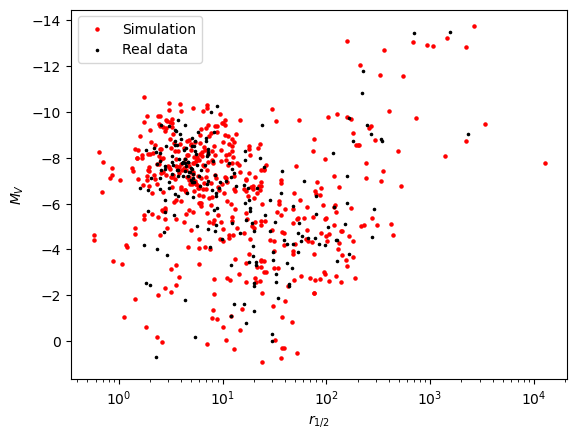

In [13]:
MV_real, hlr_real = read_ref(param)

hlr_pc = np.multiply(1.7, r_exp)
plt.scatter(hlr_pc, MV, color='r', s=5.0, label='Simulation')
plt.scatter(hlr_real, MV_real, color='k', s=2.5, label='Real data')
plt.gca().invert_yaxis()
plt.xlabel(r'$r_{1/2}$')
plt.ylabel(r'$M_V$')
plt.legend()
plt.xscale('log')
plt.show()